In [1]:
import errno
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli

%matplotlib inline

In [2]:
# Some useful constants
DRIVING_LOG_FILE = os.getcwd() + os.sep + os.pardir + '/datasets/data/driving_log.csv'
IMG_PATH = os.getcwd() + os.sep + os.pardir
IMG_PATH

'/Users/karan/Desktop/visual_navigation/iPythonNb/..'

In [3]:
def crop(image, top_percent, bottom_percent):
    """
    Crops an image according to the given parameters

    :param image: source image

    :param top_percent:
        The percentage of the original image will be cropped from the top of the image

    :param bottom_percent:
        The percentage of the original image will be cropped from the bottom of the image

    :return:
        The cropped image
    """
    assert 0 <= top_percent < 0.5, 'top_percent should be between 0.0 and 0.5'
    assert 0 <= bottom_percent < 0.5, 'top_percent should be between 0.0 and 0.5'

    top = int(np.ceil(image.shape[0] * top_percent))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))

    return image[top:bottom, :]

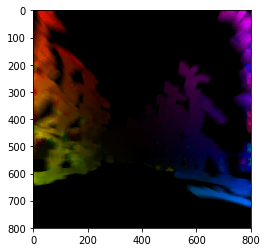

In [4]:
img = cv2.imread(IMG_PATH + '/datasets/data/IMG/100' + '.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

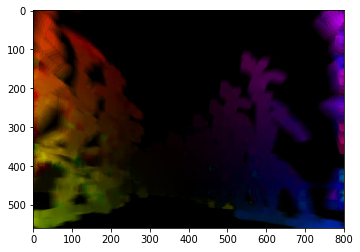

In [5]:
cropped_img = crop(img, 0.1, 0.2)
plt.imshow(cropped_img)
plt.show()

In [6]:
def random_flip(image, steering_angle, flipping_prob=0.5):
    """
    Based on the outcome of an coin flip, the image will be flipped.
    If flipping is applied, the steering angle will be negated.

    :param image: Source image

    :param steering_angle: Original steering angle

    :return: Both flipped image and new steering angle
    """
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle

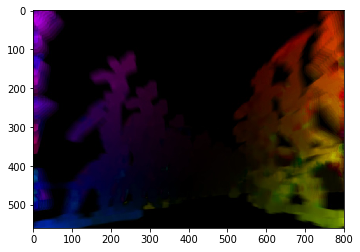

-0.1


In [7]:
flipped_img, s = random_flip(cropped_img, 0.1, 1)
plt.imshow(flipped_img)
plt.show()
print(s)

In [8]:
def random_gamma(image):
    """
    Random gamma correction is used as an alternative method changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/

    :param image:
        Source image

    :return:
        New image generated by applying gamma correction to the source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

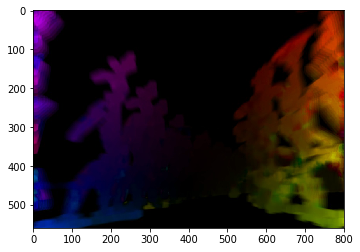

In [9]:
gamma_img = random_gamma(flipped_img)
plt.imshow(gamma_img)
plt.show()

In [10]:
def random_shear(image, steering_angle, shear_range=50):
    """
    Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk

    :param image:
        Source image on which the shear operation will be applied

    :param steering_angle:
        The steering angle of the image

    :param shear_range:
        Random shear between [-shear_range, shear_range + 1] will be applied

    :return:
        The image generated by applying random shear on the source image
    """
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return image, steering_angle

-0.2768088511494667


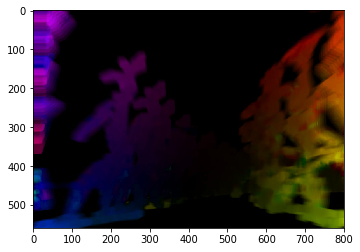

In [11]:
sheared_img, s = random_shear(gamma_img, -0.3)
plt.imshow(sheared_img)
print(s)
plt.show()

/Users/karan/.virtualenvs/dlearn/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


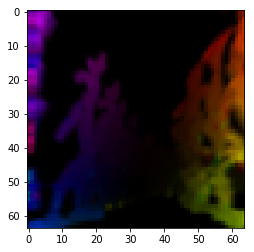

In [12]:
resize_dim=(64, 64)
resized_img = scipy.misc.imresize(sheared_img, resize_dim)
plt.imshow(resized_img)
plt.show()

In [13]:
import pandas as pd

data_frame = pd.read_csv(DRIVING_LOG_FILE, usecols=[0,1,2])
data_frame.describe(include='all')

,image,timestamp,steering
count,8308,8308.000000,8308.000000
unique,8308,NaN,NaN
top,data/IMG/924.jpg,NaN,NaN
freq,1,NaN,NaN
mean,NaN,82309.640106,-0.038346
std,NaN,37888.530685,0.120563
min,NaN,11130.000000,-0.500000
25%,NaN,49631.250000,-0.122888
50%,NaN,81877.500000,0.000000
75%,NaN,115233.750000,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x102867470>]], dtype=object)

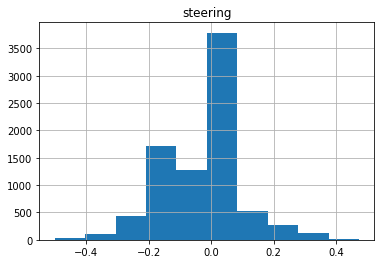

In [14]:
data_frame.hist(column='steering')

### Observations 
Data heavily biased towards left. Now I'd flip through all the images with a left steering angle, flip it and 
save it to the same folder and also add the respective steering angles to the csv file. 

In [23]:
import csv
counter = 8309
with open(DRIVING_LOG_FILE, newline='') as f:
    reader = csv.reader(f)
    firstLine = True
    for row in reader:
        if firstLine:
            firstLine = False
            continue
        steering = row[-1]
        if(float(steering) < 0.0 and float(steering) > -0.2) and counter < 12400:
            img = cv2.imread(IMG_PATH + '/datasets/' + row[0])
            flipped_img, flipped_steering = random_flip(img, float(steering), 1)
            save_path = IMG_PATH + '/datasets/data/IMG/' + str(counter) + '.jpg'
            cv2.imwrite(save_path, flipped_img)
            cv2.destroyAllWindows()
            with open(DRIVING_LOG_FILE, "a") as fp:
                wr = csv.writer(fp, dialect='excel')
                row = ["data/IMG/" + str(counter) + ".jpg", float(0), flipped_steering]
                wr.writerow(row)
            counter += 1
            print(save_path)

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8309.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8310.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8311.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8312.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8313.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8314.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8315.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8316.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8317.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8318.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8319.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8320.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8417.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8418.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8419.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8420.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8421.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8422.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8423.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8424.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8425.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8426.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8427.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8428.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8526.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8527.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8528.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8529.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8530.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8531.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8532.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8533.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8534.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8535.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8536.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8537.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8633.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8634.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8635.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8636.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8637.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8638.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8639.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8640.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8641.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8642.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8643.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8644.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8742.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8743.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8744.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8745.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8746.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8747.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8748.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8749.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8750.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8751.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8752.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8753.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8851.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8852.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8853.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8854.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8855.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8856.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8857.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8858.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8859.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8860.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8861.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8862.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8956.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8957.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8958.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8959.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8960.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8961.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8962.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8963.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8964.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8965.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8966.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/8967.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9066.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9067.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9068.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9069.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9070.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9071.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9072.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9073.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9074.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9075.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9076.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9077.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9172.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9173.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9174.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9175.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9176.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9177.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9178.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9179.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9180.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9181.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9182.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9183.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9278.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9279.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9280.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9281.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9282.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9283.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9284.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9285.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9286.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9287.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9288.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9289.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9383.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9384.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9385.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9386.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9387.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9388.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9389.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9390.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9391.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9392.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9393.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9394.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9486.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9487.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9488.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9489.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9490.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9491.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9492.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9493.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9494.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9495.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9496.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9497.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9597.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9598.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9599.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9600.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9601.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9602.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9603.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9604.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9605.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9606.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9607.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9608.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9702.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9703.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9704.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9705.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9706.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9707.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9708.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9709.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9710.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9711.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9712.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9713.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9812.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9813.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9814.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9815.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9816.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9817.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9818.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9819.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9820.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9821.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9822.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9823.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9921.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9922.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9923.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9924.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9925.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9926.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9927.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9928.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9929.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9930.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9931.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/9932.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10028.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10029.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10030.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10031.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10032.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10033.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10034.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10035.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10036.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10037.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10038.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10039.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10133.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10134.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10135.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10136.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10137.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10138.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10139.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10140.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10141.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10142.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10143.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10144.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10236.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10237.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10238.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10239.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10240.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10241.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10242.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10243.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10244.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10245.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10246.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10247.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10348.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10349.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10350.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10351.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10352.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10353.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10354.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10355.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10356.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10357.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10358.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10359.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10456.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10457.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10458.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10459.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10460.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10461.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10462.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10463.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10464.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10465.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10466.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10467.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10560.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10561.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10562.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10563.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10564.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10565.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10566.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10567.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10568.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10569.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10570.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10571.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10665.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10666.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10667.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10668.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10669.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10670.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10671.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10672.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10673.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10674.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10675.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10676.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10770.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10771.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10772.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10773.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10774.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10775.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10776.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10777.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10778.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10779.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10780.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10781.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10877.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10878.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10879.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10880.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10881.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10882.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10883.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10884.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10885.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10886.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10887.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10888.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10980.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10981.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10982.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10983.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10984.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10985.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10986.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10987.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10988.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10989.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10990.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/10991.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11087.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11088.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11089.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11090.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11091.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11092.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11093.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11094.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11095.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11096.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11097.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11098.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11195.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11196.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11197.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11198.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11199.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11200.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11201.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11202.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11203.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11204.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11205.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11206.jpg
/Users/karan/Desktop/visual_navigation/i

/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11302.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11303.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11304.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11305.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11306.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11307.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11308.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11309.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11310.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11311.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11312.jpg
/Users/karan/Desktop/visual_navigation/iPythonNb/../datasets/data/IMG/11313.jpg
/Users/karan/Desktop/visual_navigation/i

In [24]:
data_frame = pd.read_csv(DRIVING_LOG_FILE, usecols=[0,1,2])
data_frame.describe(include='all')
data_frame.hist(column='steering')

ValueError: num must be 1 <= num <= 0, not 1

In [66]:
# Dataset augmentation with random shearing since the trained model still predicts too high steering angle values
import csv
counter = 5308
with open('data/driving_log.csv', newline='') as f:
    reader = csv.reader(f)
    firstRow = True
    for row in reader:
        if firstRow:
            firstRow = False
            continue
        steering = row[-1]
        if((float(steering) > -0.05 and float(steering) < 0.05 and float(steering)!=0)):
            img = cv2.imread(row[0])
            sheared_img, sheared_steering = random_shear(img, float(steering))
            save_path = IMG_PATH + str(counter) + '.jpg'
            cv2.imwrite(save_path, sheared_img)
            cv2.destroyAllWindows()
            with open('data/augmented.csv', "a") as fp:
                wr = csv.writer(fp, dialect='excel')
                row = ["data/IMG/" + str(counter) + ".jpg", float(0), str(sheared_steering)]
                wr.writerow(row)
            counter += 1

In [67]:
data_frame = pd.read_csv('data/driving_log.csv', usecols=[0,1,2])
data_frame.describe(include='all')

,image,time,steering
count,5998,5998.000000,5998.000000
unique,5998,NaN,NaN
top,data/IMG/1271.jpg,NaN,NaN
freq,1,NaN,NaN
mean,NaN,107712.329110,0.061166
std,NaN,164053.295818,0.539497
min,NaN,0.000000,-1.500000
25%,NaN,0.000000,-0.028860
50%,NaN,0.000000,0.029264
75%,NaN,214525.000000,0.215848


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118538358>]], dtype=object)

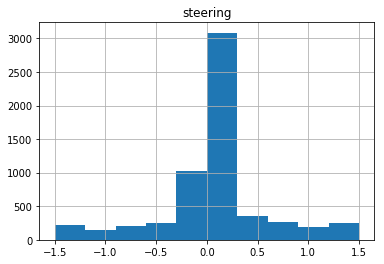

In [68]:
data_frame.hist(column='steering')